In [1]:
'''
使用VGG做车型分析
'''
# 导入包
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 设置参数
num_classes = 4
LR = 0.001
num_epochs = 100

print(device)

cuda


#### 加载数据集

In [3]:
# 定义同样的图像转换
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder('../TypeData', transform=transform)
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### 定义网络结构

In [4]:

# 加载模型
# Define the MiniVGGNet model
class MiniVGGNet(nn.Module):
    def __init__(self, num_classes = 4):
        super(MiniVGGNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # first CONV => RELU => CONV => RELU => POOL layer set
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # second CONV => RELU => CONV => RELU => POOL layer set
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # first (and only) set of FC => RELU layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.bn5(x)
        x = self.dropout3(x)

        # softmax classifier
        x = self.fc2(x)
        x = self.softmax(x)

        # return the constructed network architecture
        return x


#### 训练模型

In [5]:
import os
import torch
import torch.nn as nn

def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50, save_path="./models/vehicleType.pth"):

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        # ---------- 验证 ----------
        model.eval()
        test_loss = 0
        test_correct = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = test_correct / len(test_loader.dataset)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")

        # ---------- 保存最优模型 ----------
        if test_acc > best_acc:
            best_acc = test_acc
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model.state_dict(), save_path)

    return train_loss_list, train_acc_list, test_loss_list, test_acc_list, best_acc


In [6]:
model = MiniVGGNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list, best_acc= train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    save_path='./models/vehicleType.pth'
)


Epoch [1/100]
Train Loss: 0.9381, Train Acc: 0.8379, Test  Loss: 0.8838, Test  Acc: 0.9344
Epoch [2/100]
Train Loss: 0.8182, Train Acc: 0.9478, Test  Loss: 0.8098, Test  Acc: 0.9426
Epoch [3/100]
Train Loss: 0.7974, Train Acc: 0.9643, Test  Loss: 0.7966, Test  Acc: 0.9672
Epoch [4/100]
Train Loss: 0.7932, Train Acc: 0.9643, Test  Loss: 0.8148, Test  Acc: 0.9344
Epoch [5/100]
Train Loss: 0.7821, Train Acc: 0.9670, Test  Loss: 0.8385, Test  Acc: 0.9098
Epoch [6/100]
Train Loss: 0.7764, Train Acc: 0.9780, Test  Loss: 0.7991, Test  Acc: 0.9508
Epoch [7/100]
Train Loss: 0.7609, Train Acc: 0.9945, Test  Loss: 0.7807, Test  Acc: 0.9672
Epoch [8/100]
Train Loss: 0.7595, Train Acc: 0.9835, Test  Loss: 0.7718, Test  Acc: 0.9754
Epoch [9/100]
Train Loss: 0.7637, Train Acc: 0.9808, Test  Loss: 0.7795, Test  Acc: 0.9590
Epoch [10/100]
Train Loss: 0.7552, Train Acc: 0.9918, Test  Loss: 0.7715, Test  Acc: 0.9754
Epoch [11/100]
Train Loss: 0.7505, Train Acc: 0.9973, Test  Loss: 0.7713, Test  Acc: 0.97

#### 绘制loss和accuracy的变化曲线

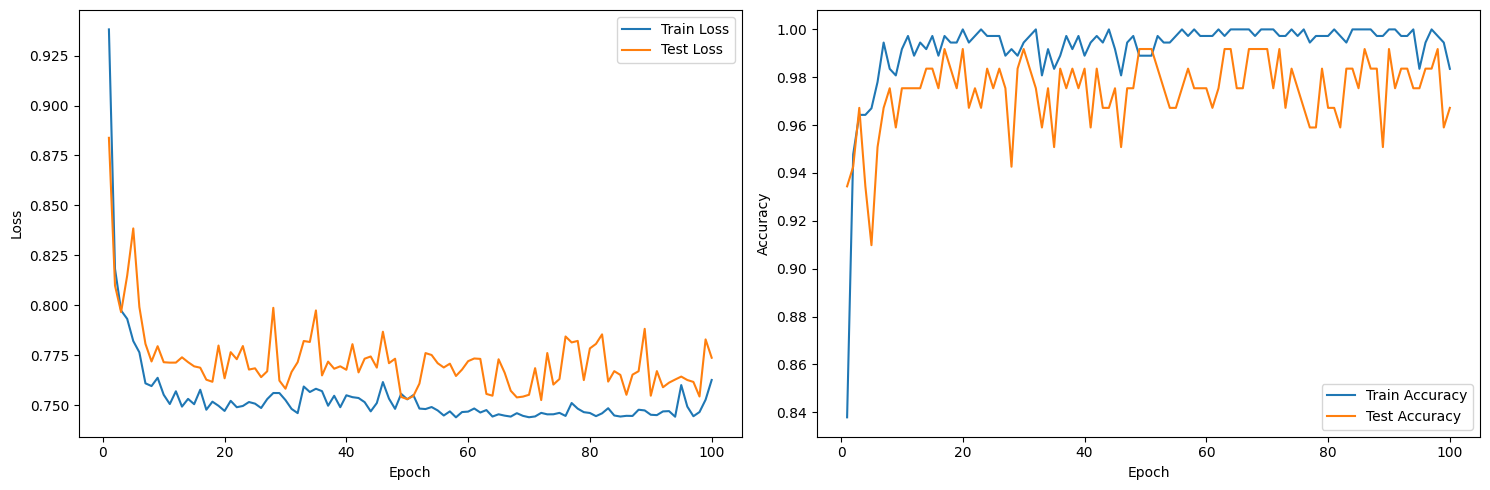

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        30
           2       0.96      1.00      0.98        25
           3       1.00      0.97      0.98        33

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122



In [8]:
import matplotlib.pyplot as plt
# 绘制loss和accuracy的变化曲线
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


from sklearn.metrics import classification_report
# 加载最佳模型
model.load_state_dict(torch.load("./models/vehicleType.pth"))

# 模型评估
model.eval()
predictions = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

print(classification_report(labels_list, predictions))
